In [1]:
from music21 import converter, instrument, note, chord, stream, midi
from google.colab import files
import random
import glob
import os
import gzip
import tarfile    
from torchvision import datasets                  
import numpy as np
import torch
import torch.nn as nn
import torch.optim
from torch.utils.data import DataLoader, random_split, Dataset
import matplotlib.pyplot as plt
from tqdm import tqdm

assert torch.cuda.is_available()

In [2]:
# Import Drive for easier saving
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
def download_data(filepath):
    if not os.path.exists(os.path.join(filepath, 'mozart_sonatas.tar.gz')):
      datasets.utils.download_url('https://github.com/Foundations-of-Applied-Mathematics/Data/raw/master/RNN/mozart_sonatas.tar.gz', filepath, 'mozart_sonatas.tar.gz', None)

    print('Extracting {}'.format('mozart_sonatas.tar.gz'))
    gzip_path = os.path.join(filepath, 'mozart_sonatas.tar.gz')
    with open(gzip_path.replace('.gz', ''), 'wb') as out_f, gzip.GzipFile(gzip_path) as zip_f:
      out_f.write(zip_f.read())

    print('Untarring {}'.format('mozart_sonatas.tar'))
    tar_path = os.path.join(filepath,'mozart_sonatas.tar')
    z = tarfile.TarFile(tar_path)
    z.extractall(tar_path.replace('.tar', ''))


In [4]:
download_data('/content/drive/MyDrive/ColabData')

Extracting mozart_sonatas.tar.gz
Untarring mozart_sonatas.tar


**Problem 1**:

Download the data.
Write a function that accepts the path to the .mid files, parses the files, and returns a list of the $119348$ pitches as strings. 
For the Chords, join the pitches of the notes in the chords with a . as in D3.D2.

Print the length of your list.


In [5]:
def parse_data(dir_path):
    pitches = list()
    #loop through the directory
    for filename in os.listdir(dir_path):
        file_path = os.path.join(dir_path, filename)
        #parse the music file
        midi = converter.parse(file_path)
        notes_to_parse = instrument.partitionByInstrument(midi).parts[0].recurse()
        #add the pitches to the list
        for element in notes_to_parse:
            #get the notes
            if isinstance(element, note.Note):
                pitches.append(str(element.pitch))
            #get the chords
            elif isinstance(element, chord.Chord):
                chords = element.pitches
                chord_pitch = list()
                for pitch in chords:
                    chord_pitch.append(str(pitch))
                pitches.append('.'.join(chord_pitch))
    #return the list of pitches
    return pitches

In [6]:
pitches = parse_data('/content/drive/MyDrive/ColabData/mozart_sonatas/mozart_sonatas')
print(len(pitches))

119348


**Problem 2.** 

Using the list returned in Problem 1, create the training and testing DataLoaders.
Make sure to do all of the following steps:


1) Convert the pitches to integers.
2) Split the data into Long tensors of length 100.
3) Create the labels.
4) Randomly split the data into training and test sets using an 80/2-0split.
5) Create the DataLoaders for both sets of data, using batch_size=128 for the training data and batch_size=1 for the test data.
 

Print the length of each DataLoader.


In [15]:
def pitch_map(pitch_list):
    pitch_set = set(pitch_list)
    map_pitches = dict()
    counter = 0
    for pitch in pitch_set:
        map_pitches[pitch] = counter
        counter += 1
    return map_pitches, pitch_set

def transform(pitch_list, map_pitches, seq_length):
    list_data = list()
    #map the pitches to integers
    mapped_pitches = list(map(map_pitches.get, pitch_list))
    #create the data
    num_pitches = len(mapped_pitches)
    for i in range(num_pitches-(seq_length+1)):
        sequence = torch.LongTensor(mapped_pitches[i:i+seq_length])
        label = mapped_pitches[i+seq_length]
        list_data.append([sequence, label])
    return list_data

def get_train_valid_data(pitch_list, map_pitches, seq_length=100):
    #transform the data
    data = transform(pitch_list, map_pitches, seq_length)
    random.shuffle(data)
    num_split = int(len(data)*0.8)
    return data[:num_split], data[num_split:]

def accuracy(y_hat, y_truth):
    """Gets average accuracy of a vector of predictions"""
    softmax = nn.LogSoftmax(dim=1)
    preds = torch.argmax(softmax(y_hat), dim=1)
    acc = torch.mean((preds == y_truth).float())
    return acc

def load_model(filename, lr=0.001, embedding_dim=500, num_layers=10):
  """ Load a saved model to continue training or evaluate """
  device = torch.device("cuda:0")
  n_vocab = len(pitch_set)
  model = RNN(n_vocab, embedding_dim=embedding_dim, num_layers=num_layers)
  model = model.to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.RMSprop(model.parameters(),lr=lr)
  checkpoint = torch.load(filename,map_location=torch.device(device))
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  last_epoch = checkpoint['epoch']
  loss = checkpoint['loss']
  model.eval() # For evaluation only
  
  return model, criterion, optimizer, last_epoch

In [8]:
#get the map of pitches and the set of pitches for vocab size
map_pitches, pitch_set = pitch_map(pitches)
reverse_pitch = {value : key for (key, value) in map_pitches.items()}
#create the train data and validation data loaders
train_data, valid_data = get_train_valid_data(pitches, map_pitches)
#shorten the validation set, it does not need to have 20000 points
valid_data = valid_data[:1000]
train_loader = DataLoader(train_data, batch_size=128,shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=1, shuffle=True)
print(len(pitch_set))
print(len(train_loader))
print(len(valid_loader))

741
745
1000


**Problem 3**

Create the network class.
Include at least $3$ LSTM layers, each followed by Dropout layers with probability $.3.$
Also have at least $2$ Linear layers.
The last LSTM layer and each of the Linear layers should be followed by a BatchNorm1d layer, for at least $3$ total batchnorm layers.
The final layer should be a Softmax activation.

Initialize the model, loss as CrossEntropyLoss, and optimizer as RMSprop.

Train the model for at least 30 epochs.

After taking a backwards step during training, scale the gradients using 
nn.utils.clip_grad_norm_(model.parameters(), 5)
This will ensure that the gradients are reasonably sized so that the model can learn.

At the end of each epoch, calculate the accuracy and mean loss on the test data.
Remember to change the model to eval() mode when running the test data and train() when running on the training data.

After the accuracy is above 95\%, plot the training and test losses versus epochs on the same plot.
Plot the accuracy versus epochs.


In [9]:
class RNN(nn.Module):
    '''
    Recurrent Neural Network Class
    '''
    def __init__(self,n_notes,embedding_dim,num_layers=5):
      super(RNN, self).__init__()
      # initialize layers
      self.hidden_size = 1024
      self.num_layers = num_layers
      self.dropout = 0.3
      self.vocab_size = n_notes
      self.embedding = nn.Embedding(self.vocab_size,embedding_dim)
      self.relu = nn.ReLU()  
      self.lstm = nn.LSTM(embedding_dim, self.hidden_size, self.num_layers,
                          batch_first=True, dropout=0.3)
      self.batch1 = nn.BatchNorm1d(self.hidden_size)
      self.batch2 = nn.BatchNorm1d(self.hidden_size//2)
      self.batch3 = nn.BatchNorm1d(self.vocab_size)
      self.dropout = nn.Dropout(0.3)
      self.linear_1 = nn.Linear(self.hidden_size, self.hidden_size//2)
      self.linear_2 = nn.Linear(self.hidden_size//2, self.vocab_size)
      self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden):
       embedding = self.embedding(x)
       lstm_out, hidden = self.lstm(embedding, hidden)
       out = self.dropout(self.relu(self.batch1(lstm_out[:,-1])))
       out = self.relu(self.batch2(self.linear_1(out)))
       out = self.batch3(self.linear_2(out))
       return out, hidden

    def initHidden(self,batch_size):
      # initialize the hidden layers
      device = torch.device('cuda:0')
      weight = next(self.parameters()).data
      h0 = weight.new(self.num_layers, batch_size, self.hidden_size).zero_().to(device)
      h1 = weight.new(self.num_layers, batch_size, self.hidden_size).zero_().to(device)
      return (h0, h1)

In [10]:
def train(start_model=None, num_epochs=40, lr=0.005, embed_size=500, num_layers=10):
    #intialize constants optimizer and objective function
    device = torch.device('cuda:0')
    num_epochs = num_epochs
    save_num = 1
    lr=lr
    if (start_model is None):
        model = RNN(len(pitch_set), embed_size, num_layers)
        model = model.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
        last_epoch=-1
    else:
        print("Loading Model")
        model, criterion, optimizer, last_epoch = load_model(start_model,
                                                             lr=lr,
                                                             embedding_dim=embed_size,
                                                             num_layers=num_layers)

    val_mean_acs = list()
    val_mean_loss = list()
    train_mean_acs = list()
    train_mean_loss = list()
    # Progress bar
    pbar = tqdm(total=len(train_loader) * num_epochs)
    for epoch in range(last_epoch+1, num_epochs):
        train_losses = list()
        train_acs = list()
        model.train()
        #get the data
        (h0,h1) = model.initHidden(128)
        for x, y_truth in train_loader:
            x, y_truth = x.to(device), y_truth.to(device)
            #zero the gradient
            optimizer.zero_grad()
            #get the prediction
            y_hat, (h0, h1) = model(x, (h0,h1))
            h0 = h0.detach()
            h1 = h1.detach()
            #get the loss
            train_loss = criterion(y_hat, y_truth)
            train_acc = accuracy(y_hat, y_truth)
            #backward propagate loss
            train_loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 5)
            #take step with the optimizer
            optimizer.step()
            #append losses and accuracies to list
            train_losses.append(train_loss.item())
            train_acs.append(train_acc.item())
            #update the status bar
            pbar.set_description('train loss:{:.4f}, train accuracy:{:.4f}.'.format(train_loss.item(), train_acc))
            pbar.update(1)    
        #average the losses
        torch.save({'epoch': epoch,
                   'model_state_dict': model.state_dict(),
                   'optimizer_state_dict': optimizer.state_dict(),
                   'loss': np.mean(train_losses),},'/content/drive/MyDrive/ColabData/model')
        train_mean_loss.append(np.mean(train_losses))
        #average the accuracies
        train_mean_acs.append(np.mean(train_acs))
        model.eval()
        #do the validation step
        val_losses = list()
        val_accs = list()
        (h0,h1) = model.initHidden(1)
        for x, y_truth in valid_loader:
            x, y_truth = x.to(device), y_truth.to(device)
            y_hat, (h0,h1) = model(x, (h0,h1))
            val_losses.append(criterion(y_hat, y_truth).item())
            val_accs.append(accuracy(y_hat, y_truth).item())
        #now get the means
        val_mean_acs.append(np.mean(val_accs))
        val_mean_loss.append(np.mean(val_losses))
    pbar.close()
    losses = (train_mean_loss, train_mean_acs, val_mean_loss, val_mean_acs)
    return model, losses

In [11]:
model, losses = train(num_epochs=5, start_model=None)

train loss:4.0412, train accuracy:0.0312.: 100%|██████████| 3725/3725 [2:07:04<00:00,  2.05s/it]


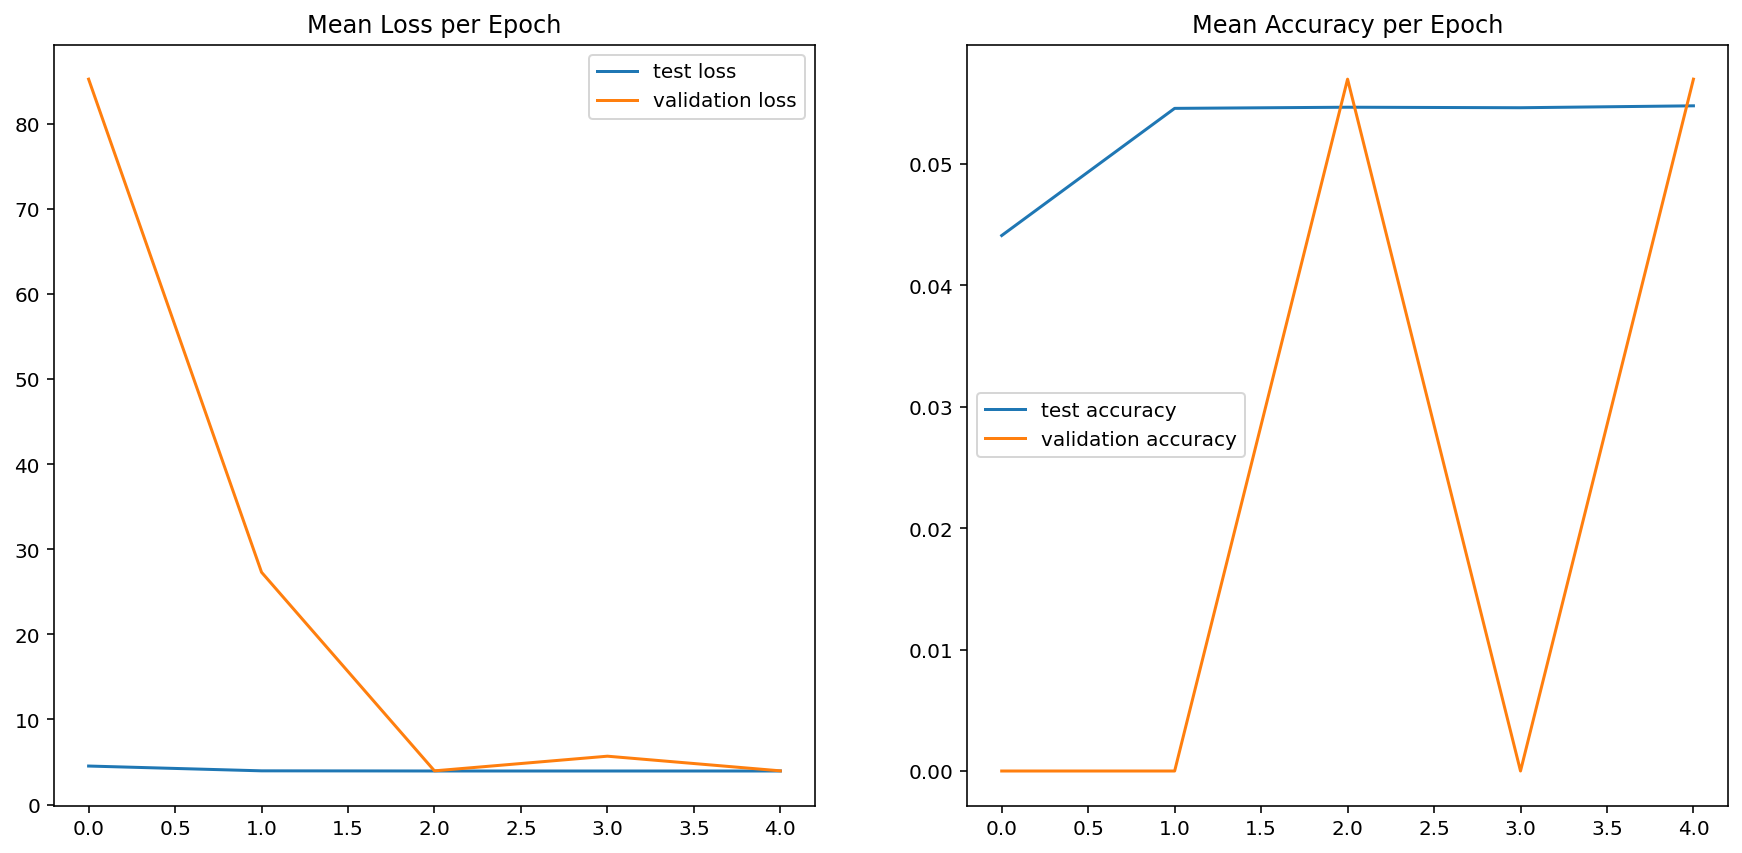

In [12]:
train_mean_loss, train_mean_acs, val_mean_loss, val_mean_acs = losses
#plot the results
fig,ax = plt.subplots(1,2,figsize=(15,7))
ax[0].plot(train_mean_loss,label='test loss')
ax[0].plot(val_mean_loss,label='validation loss')
ax[0].legend()
ax[0].set_title("Mean Loss per Epoch")
ax[1].plot(train_mean_acs,label='test accuracy')
ax[1].plot(val_mean_acs,label='validation accuracy')
ax[1].legend()
ax[1].set_title("Mean Accuracy per Epoch")
plt.show()

**Problem 4.** 
Write a function that randomly chooses a sequence in the test data and predicts
the next 500 elements. 
Return a list of the 600 pitches in the sequence.

In [16]:
def gen_music(filename, gen_len=500, index=6, lr=0.001):
  """
   Function for generating some music!
  """
  device = torch.device('cuda:0')
  model, criterion, optimizer,_ = load_model(filename)
  x, y_truth = valid_data[index]
  #resize for batch model
  x, y_truth = x.to(device), torch.LongTensor([y_truth]).to(device)
  x = x.unsqueeze(dim=0)
  y_truth = y_truth.unsqueeze(dim=0)
  x_total = x.tolist()[0]
  softmax = nn.LogSoftmax(dim=1)
  #initialize hidden
  (h0,h1) = model.initHidden(1)
  #forward pass
  pbar = tqdm(total=gen_len)
  for i in range(gen_len):
      #get the prediction
      y_hat, (h0, h1) = model(x, (h0,h1))
      #get the argmax from the softmax and change x
      y_hat = softmax(y_hat)
      pred = torch.argmax(y_hat)
      predTens = torch.LongTensor([pred]).to(device)
      x = torch.cat([x[0,1:], predTens])
      x = x.unsqueeze(dim=0)
      x_total.append(pred.item())
      pbar.set_description('Iteration: {}'.format(i))
      pbar.update(1) 
  pbar.close()
  return x_total

In [17]:
x_total = gen_music(filename='/content/drive/MyDrive/ColabData/model')

Iteration: 499: 100%|██████████| 500/500 [00:39<00:00, 12.64it/s]


**Problem 5.** 
Convert the sequence from Problem 4 into note and chord objects and save it to
'mozart.mid'.

In [18]:
def get_offset(draw):
    #offest numbers
    zero_num = 1999/(1999+1167+507)
    quarter_num = 1167/(1999+1167+507)
    half_num = 507/(1999+1167+507)
    if (draw <= half_num):
        offset = 0.5
    elif (draw <= quarter_num):
        offset = 0.25
    else:
        offset = 0.0
    return offset

def check_type(element):
    return '.' in element

def convert_to_file(filename, sequence):
    #loop through each element in the sequence
    output_notes = list()
    offset = 0
    for element in sequence:
        #check whether it is a chord or a note
        element = reverse_pitch[element]
        is_chord = check_type(element)
        if is_chord is True:
            #split according to the added pitches
            chord_pitches = element.split('.')
            notes = list()
            for pitch in chord_pitches:
                new_note = note.Note(pitch)
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            #create the chord from the notes
            new_add = chord.Chord(notes)
        else:
            new_add = note.Note(element)
            new_add.storedInstrument = instrument.Piano()
        #get the offest using a draw distribution with the given numbers
        num_draw = np.random.uniform()
        offset += get_offset(num_draw)
        new_add.offset = offset
        output_notes.append(new_add)

    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp=filename)

In [19]:
convert_to_file('/content/drive/MyDrive/ColabData/mozart.mid', x_total)